In [1]:
#%load_ext line_profiler
#%load_ext memory_profiler

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import util
import models
import platform

from os.path import expanduser
from os import path
import logging

# logging.basicConfig(level=logging.DEBUG)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import preprocess

import numpy as np
from scipy.io import loadmat

from dstools import plot

LOCAL = platform.system() == 'Darwin'

Using TensorFlow backend.


In [4]:
if LOCAL:
    yass.set_config("../config/49-local.yaml")
else:
    yass.set_config("../config/49-lab.yaml")

CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'nnet')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

if LOCAL:
    path_to_here = path.expanduser('~/dev/lab/private-yass/nnet')
else:
    path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [6]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

gt = gt[2:-1]
gt[:, 1] = gt[:, 1] - 1

# compensate alignment
gt[:, 0] = gt[:, 0] + 10

In [7]:
n_spikes = 20000

min_amplitude = 5
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [21]:
templates, _ = preprocess(CONFIG, gt,
                          path_to_standarized,
                          chosen_templates)

100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


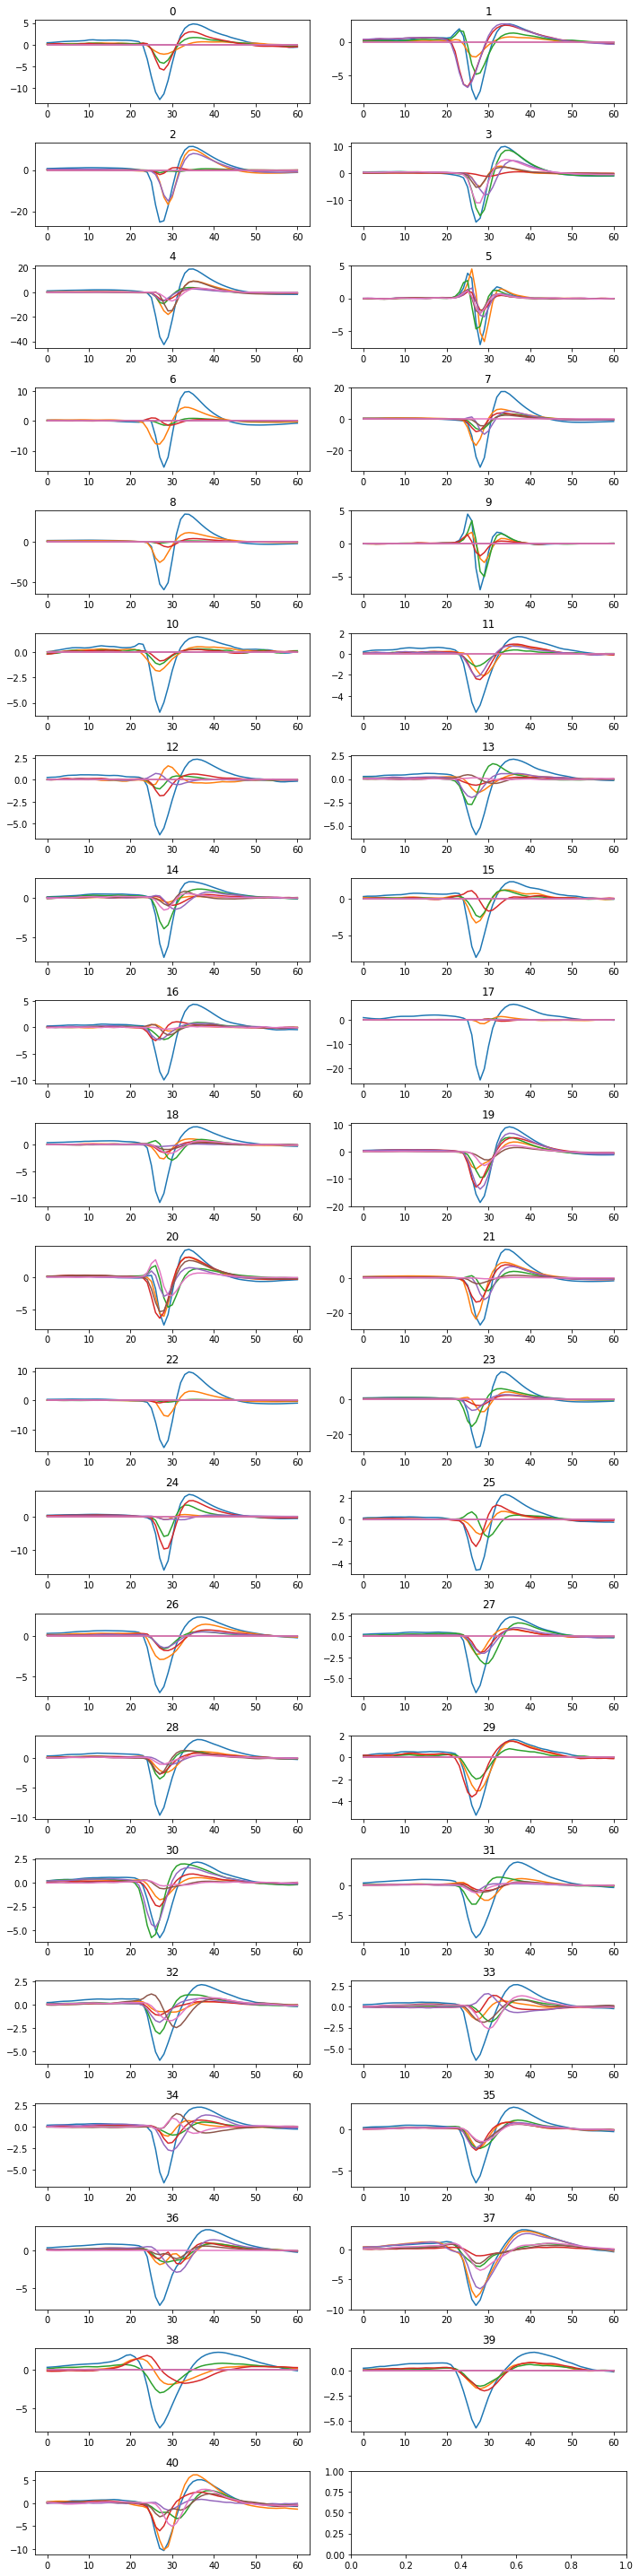

In [18]:
plot.grid_from_array(templates, axis=0, figsize=(10, 40),
                     max_cols=2)

In [ ]:
def spike_amplitudes_from_spikes(spikes):
    abs_value = np.abs(spikes)
    
    amplitudes = np.max(abs_value, axis=(1, 2))
    main_channels = np.argmax(np.max(abs_value, axis=1), axis=1)

    return amplitudes, main_channels

In [ ]:
plt.rcParams['figure.figsize'] = (10, 6)
plot.grid_from_array(np.abs(se.templates), axis=0, elements=[2, 4, 8])

In [ ]:
templates = np.copy(se.templates)
templates = np.concatenate((templates, np.zeros((49, 21, 1))), axis=2)

In [ ]:
amps, main_channels = spike_amplitudes_from_spikes(se.templates)

In [ ]:
print(amps[2], main_channels[2])

In [ ]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps, kde=False)

In [ ]:
# this looks wrong
plt.rcParams['figure.figsize'] = (10, 6)
se.plot_templates(group_ids=[2, 10])

In [ ]:
plt.rcParams['figure.figsize'] = (10, 9)
plot.grid_from_array(se.templates, axis=0, elements=[2, 4, 10])

In [ ]:
from yass.geometry import make_channel_index

In [ ]:
ch_index = make_channel_index(re.neigh_matrix, re.geom)

In [ ]:
n_templates, waveform_length, n_channels = templates.shape

small_templates = np.empty((n_templates, waveform_length, 7))

for i in range(n_templates):
    main_channel = main_channels[i]
    neighbors = ch_index[main_channel]
    small_templates[i] = templates[i][:, neighbors]

In [ ]:
plt.rcParams['figure.figsize'] = (10, 9)
plot.grid_from_array(small_templates, axis=0, elements=[2, 4, 8])

In [ ]:
plt.rcParams['figure.figsize'] = (10, 100)
plot.grid_from_array(small_templates, axis=0, max_cols=2, sharey=True)

## Generating training data

In [8]:
# shengao's params

min_amplitude = 3

# not used in current implementation
max_amp = 15

n_spikes = 30000

chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48]

noise_ratio=2
collision_ratio=1
misalign_ratio=1
misalign_ratio2=1

multi_channel = True

In [10]:
logging.basicConfig(level=logging.DEBUG)

(x_detect, y_detect,
 x_triage, y_triage,
 x_ae, y_ae) = make.training_data(CONFIG, gt, chosen_templates,
                                  min_amplitude, n_spikes,
                                  data_folder=path_to_experiment,
                                  multi_channel=True,
                                  noise_ratio=noise_ratio)

INFO:yass.templates.preprocess:Getting templates...
INFO:yass.templates.util:Computing templates...
DEBUG:yass.batch.generator:Max memory: 500 MB. Itemsize: 4 bytes
INFO:yass.batch.batch:Applying function yass.templates.util.compute_weighted_templates...
  0%|          | 0/3 [00:00<?, ?it/s]DEBUG:yass.batch.generator:Observations per channel: 6,000,000. Number of channels: 49. Total observations: 294,000,000 Size to traverse: 1.1 GB
DEBUG:yass.batch.generator:Max observations per batch: 131,071,962 (500 MB), 2,674,938 max observations per channel
DEBUG:yass.batch.generator:Number of batches: 3
DEBUG:yass.batch.generator:Last batch with 31,856,076 observations (127424304), 650,124 observations per channel
DEBUG:yass.batch.util:Processing batch 0...
DEBUG:yass.batch.util:Applying function in batch 0 with size (2675018, 49)
DEBUG:yass.batch.util:Done Applying function in batch 0...
 33%|███▎      | 1/3 [00:03<00:07,  4.00s/it]DEBUG:yass.batch.util:Processing batch 1...
DEBUG:yass.batch.ut

In [9]:
print(f'Training set sizes:\n\tdetect:{x_detect.shape}\n\ttriage:{x_triage.shape}\n\tautoencoder:{x_ae.shape}')

Training set sizes:
	detect:(150150, 21, 7)
	triage:(60060, 21, 7)
	autoencoder:(274890, 21)


In [10]:
print(x_ae.shape, y_ae.shape)

(274890, 21) (274890, 21)


In [ ]:
# compute amplitude for positive and negative samples in the detect training set
x_detect_positive = x_detect[y_detect == 1]
x_detect_negative = x_detect[y_detect == 0]

amps_positive = np.max(np.abs(x_detect_positive), axis=(1, 2))
amps_negative = np.max(np.abs(x_detect_negative), axis=(1, 2))

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_detect_positive, axis=0, elements=10)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_detect_negative, axis=0, elements=10)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_positive, kde=False)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_negative, kde=False)

In [ ]:
x_triage_positive = x_triage[y_triage == 1]
x_triage_negative = x_triage[y_triage == 0]

In [ ]:
print(x_triage_positive.shape, x_triage_negative.shape)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_triage_positive, axis=0, elements=10, sharey=True)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_triage_negative, axis=0, elements=10, sharey=True)

# Training

In [9]:
# shengaos params

# may be too much, loss doesnt improve after a a couple hundred iters
# maybe implement early stopping
n_iter = 70000

n_batch = 512
l2_reg_scale = 0.00000005
train_step_size =  0.001

In [10]:
n_iter = 10000

## Detector training

In [11]:
x_detect.shape

(150150, 21, 7)

In [12]:
detect_name = path.join(path_to_here, 'models', 'detect-'+util.directory()+'.ckpt')

filters_detect = [8, 4]

#shengao's
filters_detect = [16, 8]

_, waveform_length, n_neighbors =  x_detect.shape

detector = NeuralNetDetector(detect_name, filters_detect,
                             waveform_length, n_neighbors,
                             threshold=0.5,
                             channel_index=CONFIG.channel_index,
                             n_iter=n_iter)

detector.fit(x_detect, y_detect)

Tr loss: 0.019374017, Val loss: 0.016275488: 100%|██████████| 10000/10000 [00:58<00:00, 170.59it/s]


In [13]:
detect_name

'/home/Edu/dev/private-yass/nnet/models/detect-11-Jul-2018@21-00-57.ckpt'

## Triage training

In [ ]:
triage_name = path.join(path_to_here, 'models', 'triage-'+util.directory()+'.ckpt')
#filters_triage = [8, 4]
filters_triage = [12, 6]

_, waveform_length, n_neighbors = x_triage.shape

triage = NeuralNetTriage(triage_name, filters_triage,
                         waveform_length=waveform_length,
                         threshold=0.5,
                         n_neighbors=n_neighbors,
                         n_iter=n_iter)

triage.fit(x_triage, y_triage)

## Autoencoder training

In [ ]:
ae_name = path.join(path_to_here, 'models', 'ae-'+util.directory()+'.ckpt')

_, waveform_length = x_ae.shape

encoder = AutoEncoder(ae_name, waveform_length, n_features=3)
encoder.fit(x_ae)

# Evaluation

## Detect evaluation

In [ ]:
y_pred = detector.predict(detector.x_test)
y_true = detector.y_test

print(metrics.classification_report(y_true, y_pred))

In [ ]:
sk_plot.confusion_matrix(y_true, y_pred, target_names=['Not spike (0)', 'Spike (1)'])

In [ ]:
fn_idx = np.logical_and(y_true == NeuralNetDetector.SPIKE, y_pred == NeuralNetDetector.NOT_SPIKE)
fp_idx = np.logical_and(y_true == NeuralNetDetector.NOT_SPIKE, y_pred == NeuralNetDetector.SPIKE)

fns = detector.x_test[fn_idx]
fps = detector.x_test[fp_idx]

fns_amps = np.max(np.abs(fns), axis=(1, 2))
fps_amps = np.max(np.abs(fps), axis=(1, 2))

In [ ]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fns_amps, kde=False)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fps_amps, kde=False)

## Triage evaluation

In [ ]:
y_pred = triage.predict(triage.x_test)
y_true = triage.y_test

print(metrics.classification_report(y_true, y_pred))

In [ ]:
sk_plot.confusion_matrix(y_true, y_pred, target_names=['Collided (0)', 'Clean (1)'],
                        normalize=False)

In [ ]:
fn_idx = np.logical_and(y_true == NeuralNetTriage.CLEAN, y_pred == NeuralNetTriage.COLLIDED)
fp_idx = np.logical_and(y_true == NeuralNetTriage.COLLIDED, y_pred == NeuralNetTriage.CLEAN)

fns = triage.x_test[fn_idx]
fps = triage.x_test[fp_idx]

fns_amps = np.max(np.abs(fns), axis=(1, 2))
fps_amps = np.max(np.abs(fps), axis=(1, 2))

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(fns, axis=0, elements=10)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(fps, axis=0, elements=10)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fns_amps, kde=False)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fps_amps, kde=False)

# Running detection step

In [ ]:
from copy import copy

yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

cfg = copy(CONFIG._data)

# cfg['detect']['neural_network_detector']['filename'] = detect_name
# cfg['detect']['neural_network_triage']['filename'] = triage_name
# cfg['detect']['neural_network_autoencoder']['filename'] = ae_name

output_dir = 'tmp'

cfg.pop('channel_groups')
cfg.pop('channel_index')
cfg.pop('geom')
cfg.pop('neigh_channels')
cfg.pop('spike_size')

yass.set_config(cfg)

In [ ]:
CONFIG = read_config()

print(CONFIG['detect']['neural_network_detector']['filename'])
print(CONFIG['detect']['neural_network_triage']['filename'])
print(CONFIG['detect']['neural_network_autoencoder']['filename'])

In [ ]:
(path_to_standarized,
 standarized_params,
 whiten_filter) = preprocess.run(output_directory=output_dir,
                                 if_file_exists='skip')

In [ ]:
_, spikes_clear, spikes_all  = detect.run(path_to_standarized, standarized_params, whiten_filter)

In [ ]:
print(f'All spikes: {spikes_all.shape[0]:,}\nClear spikes: {spikes_clear.shape[0]:,}')